# Version information

In [1]:
%matplotlib notebook
from PySide2.QtWidgets import *
from datetime import date
print("Running date:", date.today().strftime("%B %d, %Y"))
import pyleecan
print("Pyleecan version:" + pyleecan.__version__)
import SciDataTool
print("SciDataTool version:" + SciDataTool.__version__)

Running date: July 01, 2022
Pyleecan version:1.4.0
SciDataTool version:2.4.9


# How to compute magnetic forces using Force Module

This tutorial shows the different steps to **compute magnetic forces** with pyleecan.
 
The notebook related to this tutorial is available on [GitHub](https://github.com/Eomys/pyleecan/tree/master/Tutorials/tuto_Force.ipynb).

To compute Forces, pyleecan first needs an [**OutMag**](http://pyleecan.org/pyleecan.Classes.OutMag.html) containing airgap flux density. So first a simulation is created to compute the flux in FEMM, with imposed currents, using periodicity and parallelization to reduce execution time. The corresponding objects are introduced in the [How to define a simulation to call FEMM tutorial](https://www.pyleecan.org/tuto_Simulation_FEMM.html)

d:\github\pyleecan-public\pyleecan\Methods\Machine\Machine\plot.py:189: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'Toyota_Prius'}, xlabel='Position along x-axis [m]', ylabel='Position along y-axis [m]'>)

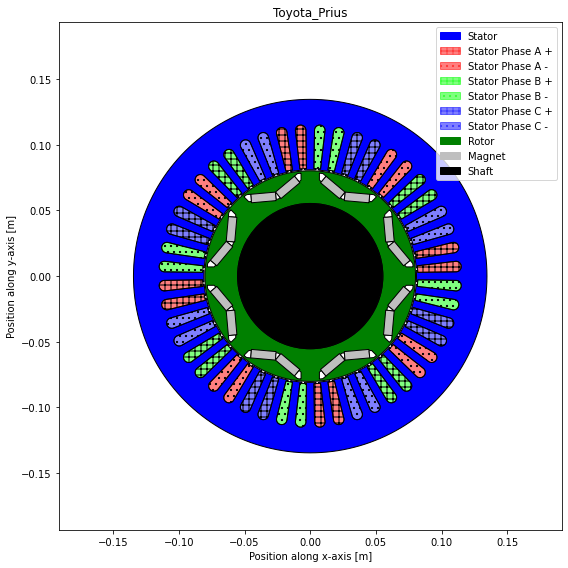

In [3]:
%matplotlib inline
from numpy import exp, sqrt, pi
from os.path import join
from pyleecan.Classes.Simu1 import Simu1
from pyleecan.Classes.InputCurrent import InputCurrent
from pyleecan.Classes.MagFEMM import MagFEMM
from pyleecan.Classes.ForceMT import ForceMT
from pyleecan.Classes.Output import Output
from pyleecan.Classes.OPdq import OPdq
from pyleecan.Functions.load import load
from pyleecan.definitions import DATA_DIR

# Load the machine
Toyota_Prius = load(join(DATA_DIR, "Machine", "Toyota_Prius.json"))
Toyota_Prius.plot()

In [4]:
# Simulation initialization
simu = Simu1(name="FEMM_periodicity", machine=Toyota_Prius)

# Definition of the enforced output of the electrical module
simu.input = InputCurrent(
    Na_tot=252 * 8,
    Nt_tot=50 * 8,
    OP=OPdq(N0=1000),
)
# Set Id/Iq according to I0/Phi0
simu.input.OP.set_I0_Phi0(I0=250 / sqrt(2), Phi0=140*pi/180)

# Definition of the magnetic simulation: with periodicity
simu.mag = MagFEMM(is_periodicity_a=True, is_periodicity_t=True, nb_worker=4)

## Force Module
All models related to forces inherit the abstract class [**Force**](http://pyleecan.org/pyleecan.Classes.Force.html). The [**ForceMT**](http://pyleecan.org/pyleecan.Classes.ForceMT.html) class inherits from [**Force**](http://pyleecan.org/pyleecan.Classes.Force.html) class and is dedicated to the computation of air-gap surface force based on the Maxwell stress tensor \[[source](https://eomys.com/IMG/pdf/comparison-main-magnetic.pdf)\]. 

[**Simu1**](http://pyleecan.org/pyleecan.Classes.Simu1.html) is an object meant to define simulation that runs sequentially several models by assuming a weak coupling. By setting both simu.mag and simu.force, the simulation will first call the [**MagFEMM**](http://pyleecan.org/pyleecan.Classes.MagFEMM.html) model to compute the flux, the results will be stored in an [**OutMag**](http://pyleecan.org/pyleecan.Classes.OutMag.html) that will then be used as an input for the computation of [**ForceMT**](http://pyleecan.org/pyleecan.Classes.ForceMT.html) which are then stored in an [**OutForce**](http://pyleecan.org/pyleecan.Classes.OutForce.html) object.

In [5]:
from pyleecan.Classes.ForceMT import ForceMT

# Add the Force model
simu.force = ForceMT(is_periodicity_a=True, is_periodicity_t=True)

# Run simulations both models
out = simu.run()

[14:32:51] Starting running simulation FEMM_periodicity (machine=Toyota_Prius)
[14:32:51] Starting Magnetic module
[14:32:53] Solving time steps: 0%
[14:32:53] Solving time steps: 0%
[14:32:54] Solving time steps: 0%
[14:32:54] Solving time steps: 0%
[14:32:59] Solving time steps: 25%
[14:32:59] Solving time steps: 25%
[14:33:00] Solving time steps: 25%
[14:33:01] Solving time steps: 25%
[14:33:04] Solving time steps: 50%
[14:33:05] Solving time steps: 50%
[14:33:05] Solving time steps: 50%
[14:33:06] Solving time steps: 50%
[14:33:10] Solving time steps: 75%
[14:33:10] Solving time steps: 75%
[14:33:12] Solving time steps: 75%
[14:33:12] Solving time steps: 75%
[14:33:16] Solving time step: 100%
[14:33:16] Solving time step: 100%
[14:33:17] Solving time step: 100%
[14:33:17] Solving time step: 100%
[14:33:17] Starting Force module
[14:33:17] End of simulation FEMM_periodicity


Once the simulation is finished, the results are stored in the force part of the output (i.e. out.force_ ) and we can call different plots. This object contains:   
- *Time*: Time axe
- *Angle*: Angular position axe   
- *AGSF*: Airgap surface force (Radial and Tangential component)
    
**Output** object embbed different plot to visualize results easily. You can find a dedicated tutorial [here](https://www.pyleecan.org/tuto_Plots.html).

Here are some example of useful force related plots.

c:\python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


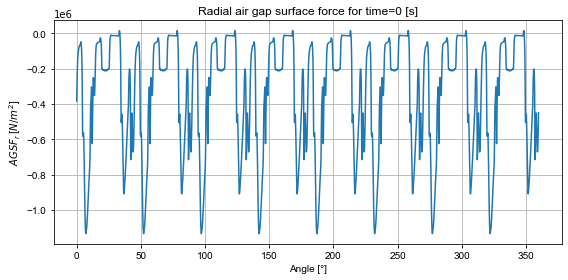

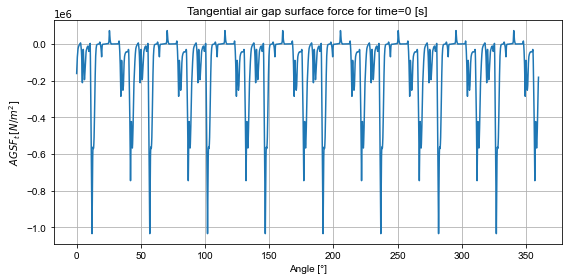

In [6]:
# AGSF as a function of angle in degre (for time=0) both radial and tangential
out.force.AGSF.plot_2D_Data("angle{°}")

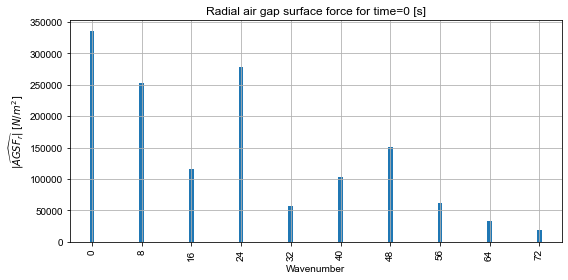

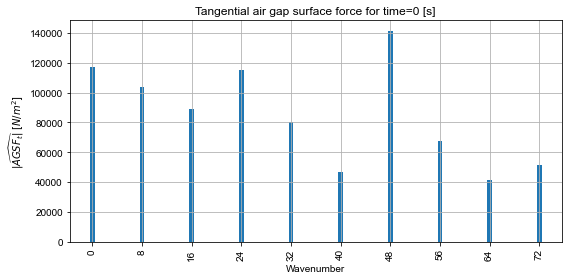

In [7]:
# FFT of AGSF on angle 
out.force.AGSF.plot_2D_Data("wavenumber=[0,78]")

c:\python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
c:\python38\lib\site-packages\SciDataTool\Functions\Plot\plot_2D.py:539: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


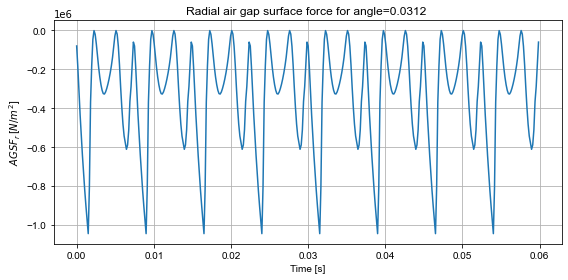

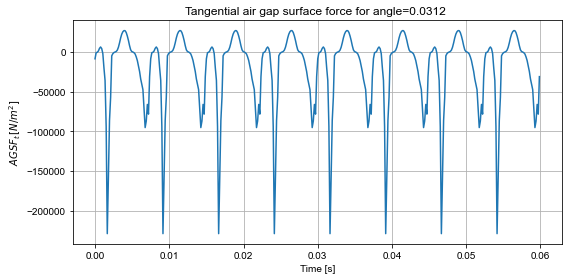

In [8]:
from numpy import pi

# Plot the air-gap force as a function of time for a given angle
out.force.AGSF.plot_2D_Data("time","angle[10]", is_auto_ticks=False)

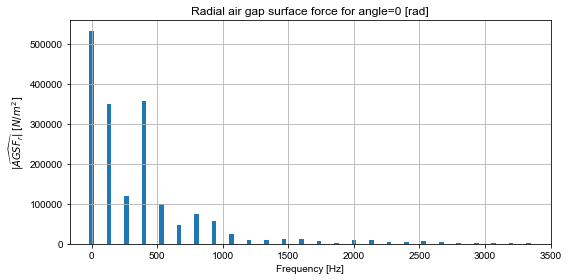

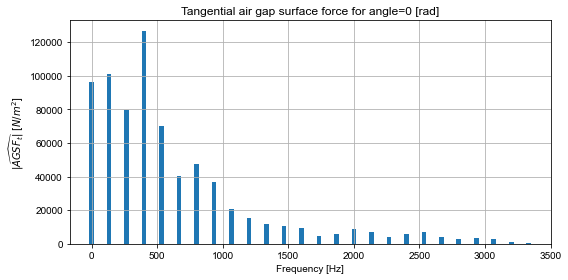

In [9]:
# Plot the FFT of time 
out.force.AGSF.plot_2D_Data("freqs=[0,4000]", is_auto_ticks=False)

The following plot displays the radial air-gap surface force over time and angle. 

c:\python38\lib\site-packages\SciDataTool\Functions\Plot\plot_3D.py:374: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


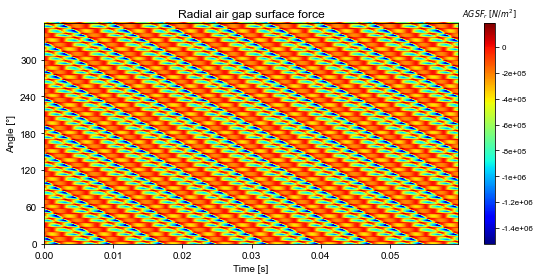

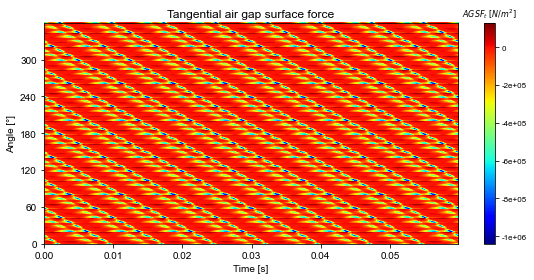

In [10]:
# Plot the tangential force as a function of time and space
out.force.AGSF.plot_3D_Data("time", "angle{°}", is_2D_view=True)